# Professional XGBoost Workflow For Beginners with GPU-acceleration 

## 👋 Introduction

In this notebook, we’ll build a real-world machine learning workflow using the full <a href="https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data" target="_blank">2023 Yellow Taxi Trip Data from the City of New York</a>, or a smaller version of it located in the current directory: **Distilled_2023_Yellow_Taxi_Trip_Data.csv**.

Instead of "hello world" examples, we’ll use millions of real taxi rides to explore what actually makes people tip more in taxis — distance, time of day, passengers, or something else? Step by step, we’ll clean and prepare the data, handle missing values and anomalies, and train an XGBoost model on GPU using cuDF Pandas and RAPIDS RMM for memory management.

I hope this notebook brings you clarity, confidence, and inspiration on your data-science journey - keep learning and exploring! 🚀

## ⚙️ Manage GPU Memory

When working with large datasets, we need to manage how memory is distributed between different parts of the workflow. Since we’re running everything on the GPU, we can use **RAPIDS Memory Manager (RMM)** to control how VRAM is allocated — deciding which module gets what, and keeping our workflow stable and efficient.

Below, we set the `initial_pool_size` to about half of your GPU’s total VRAM. For example: if you have RTX 4080 with 16GB of VRAM - then set `initial_pool_size="8GB"`. 

When we do so, we allocate half of our memory to cuDF Pandas, and leave the rest of it available. cuDF pandas is using RMM by default, so if we restrict the RMM memory pool, it also restricts cuDF Pandas. XGBoost is not using RMM by default, but we can set it up to.

In [1]:
import rmm

rmm.reinitialize(pool_allocator=True, initial_pool_size="8GB")

## 📥 Load Dataset

When we work with giant datasets, traditional pandas often runs out of memory or slows down dramatically.
To solve this, we’ll load our data with **cuDF Pandas**, which runs the good old Pandas commands — just on the GPU! 🐼

It’s a simple one-line switch that gives us full GPU acceleration with no code changes. So instead of chunking or splitting our files to run on CPU, we can just load millions of rows smoothly, keeping the workflow clean and professional.

In [2]:
%load_ext cudf.pandas
import pandas as pd

# load 5-million rows from the Yellow Taxi Trip Data
data = pd.read_csv("Distilled_2023_Yellow_Taxi_Trip_Data.csv")

# preview the last 5 rows
data.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4999995,1,05/01/2023 03:01:24 PM,05/01/2023 03:08:56 PM,1,1.10,1,N,107,137,2,9.3,2.5,0.5,0.00,0.0,1.0,13.30,2.5,0.0
4999996,2,12/16/2023 06:04:34 PM,12/16/2023 06:12:02 PM,1,0.72,1,N,68,186,1,8.6,0.0,0.5,1.00,0.0,1.0,13.60,2.5,0.0
4999997,2,08/28/2023 04:14:44 PM,08/28/2023 04:24:36 PM,1,1.85,1,N,43,142,1,12.1,2.5,0.5,4.65,0.0,1.0,23.25,2.5,0.0
4999998,1,06/29/2023 07:14:52 PM,06/29/2023 07:27:39 PM,1,2.60,1,N,246,143,1,14.9,5.0,0.5,5.30,0.0,1.0,26.70,2.5,0.0
4999999,1,12/18/2023 05:27:45 PM,12/18/2023 05:45:34 PM,1,2.50,1,N,170,236,1,15.6,5.0,0.5,4.40,0.0,1.0,26.50,2.5,0.0


## 🧹 Initial Cleanup - Missing Values

### Find Missing Values 🔎 
Before we clean anything, we first need to know how bad the damage is. Let’s check **how many missing values we have in each column** — this gives us a clear picture of what needs fixing, and what we can safely ignore.

Once we know where the gaps are, we can decide how to handle them.

In [3]:
data.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          170476
trip_distance                 0
RatecodeID               170476
store_and_fwd_flag       170476
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     170476
airport_fee              170476
dtype: int64

### Replace Missing Values 🔧 

Not all missing values mean the same thing — so we handle each column based on logic, not guesswork or laziness!

If a **fee** is missing, it probably means the passenger didn’t pay that fee at all, so we can that the **fee is 0**.
But if something like the **passenger count** is missing, it doesn’t mean there were no passengers — it’s more likely that the driver simply **forgot to enter it**.

That’s why we treat each case differently, using common sense before touching the data.
Specifically: `RatecodeID` stores <a target="_blank" href="https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf">internal labels</a> where the lable for "unknown" is 99. So we replace the missing values in that column with 99. 
<br>
But when it comes to `store_and_fwd_flag`, since it stores information that neither the driver nor the passenger is aware of - it has no chance of affecting the size of tip, and therefore we delete this column altogether.

In [4]:
# fill with 0
data["airport_fee"] = data["airport_fee"].fillna(0)
data["congestion_surcharge"] = data["congestion_surcharge"].fillna(0)
# fill with other numbers
data["passenger_count"] = data["passenger_count"].fillna(data["passenger_count"].mean())
data["RatecodeID"] = data["RatecodeID"].fillna(99)
# drop non-meaningful column
data = data.drop(columns=["store_and_fwd_flag"])

### Verify Values Were Replaced ✅ 
Before moving forward, let’s double-check that all missing values were actually filled. It’s always good practice to confirm the cleanup worked before we continue — otherwise, those gaps might cause errors later during training.

In [5]:
data.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

## 🤖 Machine Learning

### Train and Test Split 🖖

Before we train anything, we need to **split our data into two parts** — one for training, and one for testing.
The model learns patterns from the training examples, and then we check how well it performs on new, unseen examples — the test data. 

We’ll also separate **targets** (the values we want to predict, in our case, the tip amount) from **features** (the rest of the columns). The bigger portion always goes to training, because the more examples the model sees, the better it can learn real-world patterns.

In [6]:
def train_test_split(data):
    """
    prepare data for training
    """
    # shuffle dataset
    data = data.sample(frac=1, random_state=432).reset_index(drop=True)
    
    # extract features and targets
    targets = data["tip_amount"]
    features = data.drop(columns=["tip_amount", "tpep_pickup_datetime", "tpep_dropoff_datetime"])
    
    # reserve all but the last 1000000 rows for training - anything else for testing
    x_train, x_test = features.iloc[:-1000000], features.iloc[-1000000:]
    y_train, y_test = targets.iloc[:-1000000], targets.iloc[-1000000:]
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_split(data)

### Train Model 🧠

Now it’s time to train our model using XGBoost — one of the fastest and most reliable machine learning algorithms out there! To keep it fast, we will use our model to use `device="cuda"` - and that way we can leverage our GPU not only for data sceince - but also for machine learning.

So in the cell below, **training will update our model** and makes it smarter, while **testing will check that the model learned rather than memorized**. For training, we give our model the entire learning material - a bunch of questions (train features) along with matching answers (train targets). At testing, we give our model only the exam questions (test features), and we let it figure out the exam answers on its own! we just let it predict them. Then, to evaluate it, we compare the predictions with the actual values from the dataset (test targets) to see just how well our model performs.

In our case, in the function below, we bundle training with testing, retrieving the trained model, along with its' predicted "exam answer sheet". 

In [7]:
from xgboost import XGBRegressor

def training_run(x_train, y_train, x_test):
    # create model
    model = XGBRegressor(device="cuda", enable_categorical=True)
    # train model
    model.fit(x_train, y_train)
    # test model
    predictions = model.predict(x_test)
    return model, predictions

model1, predictions = training_run(x_train, y_train, x_test)

### Evaluate Model 📏 

Now that our model made its predictions, we need a way to measure how accurate they are.
For that, we’ll use a metric called **Mean Squared Error (MSE)** — it calculates how far our predictions are from the real values. The smaller the number, the smaller the difference between the prediction and the actual value — meaning our model gets smarter!

We’ll use this score to track how much our results improve as we keep cleaning and optimizing the data.
We call our initial score a **baseline**.

In [8]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
mse

1.125281266868761

### Discuss Results 🔉

MSE of 1.12 means that our model is **wrong by 1.12 USD** on average, so if the model predicts that the tip should be 2.50 USD - then the actual tip is either 3.62 or 1.38 USD.

## 💪 Data Optimization

### Find Anomalies 🔎
Now that our model works, it’s time to make our data even cleaner and more reliable.
We’ll start by summarizing the dataset — checking the minimum, maximum, and average for every numeric column.

This quick scan helps us spot anything that doesn’t make sense, like negative fares, impossible distances, or other strange outliers. 

In [9]:
data.select_dtypes(include="number").agg(["min", "max", "mean"]).T

,min,max,mean
DOLocationID,1.00,265.00,163.937378
PULocationID,1.00,265.00,165.211125
RatecodeID,1.00,99.00,4.957792
VendorID,1.00,6.00,1.738975
airport_fee,-1.75,1.75,0.135050
congestion_surcharge,-2.50,2.50,2.188012
extra,-7.50,67.33,1.556050
fare_amount,-768.10,2100.00,19.500016
improvement_surcharge,-1.00,1.00,0.979552
mta_tax,-0.50,4.00,0.485634


### Handle Anomalies 🚦
Some values in real-world data simply don’t make sense — and it’s our job to catch them! 
- A negative charge is probably a refund.
- A trip distance of 0 means there was no actual trip
- A distance of hundreds of thousands of miles is clearly an input error.

To fix this, we’ll remove unrealistic rows and keep only the sensible ranges — for example, trips longer than half a mile but still within reasonable driving distance (that we get to decide! 😉). This helps the model focus on real, meaningful examples while ignoring the noise.

In [10]:
data = data[data["trip_distance"] > 0.5]
data = data[data["trip_distance"] < 100]
data = data[~data.select_dtypes("number").lt(0).any(axis=1)]

### Verify Anomaly Handling ✅
After cleaning, let’s double-check that the anomalies are actually gone.

In [11]:
data.select_dtypes(include="number").agg(["min", "max", "mean"]).T

,min,max,mean
DOLocationID,1.00,265.00,163.569507
PULocationID,1.00,265.00,164.950451
RatecodeID,1.00,99.00,4.288704
VendorID,1.00,6.00,1.747534
airport_fee,0.00,1.75,0.144952
congestion_surcharge,0.00,2.50,2.258322
extra,0.00,67.33,1.603440
fare_amount,0.00,633.00,20.328010
improvement_surcharge,0.00,1.00,0.999500
mta_tax,0.00,4.00,0.496888


### Handle Total Amount Anomaly 💳

Every yellow cab trip starts with a base fare of 3.00 USD, plus about 0.70 USD per mile, per <a href="https://www.nyc.gov/site/tlc/passengers/taxi-fare.page" target="_blank">NYC official website</a>.
Since we’ve already set a minimum trip distance of 0.5 miles, the lowest possible total fare should be around $3.70.

So if we see anything lower than that, it’s safe to assume it’s not a real trip — maybe a data entry error, or a customer who never showed up, or just a broken record.

In [12]:
data = data[data["total_amount"] > 3.7]

In [13]:
# verify new total amount
data.select_dtypes(include="number").agg(["min", "max", "mean"]).T

,min,max,mean
DOLocationID,1.00,265.00,163.570355
PULocationID,1.00,265.00,164.952203
RatecodeID,1.00,99.00,4.286890
VendorID,1.00,6.00,1.747576
airport_fee,0.00,1.75,0.144956
congestion_surcharge,0.00,2.50,2.258500
extra,0.00,67.33,1.603564
fare_amount,0.00,633.00,20.329613
improvement_surcharge,0.00,1.00,0.999531
mta_tax,0.00,4.00,0.496920


## 💪 Second Training Run

Now that we’ve cleaned up the data and removed anomalies, it’s time to retrain the model and see how much it improved. This is where all that careful data cleaning is supposed to pay off!

In [14]:
# new train and test split
x_train, x_test, y_train, y_test = train_test_split(data)
# train model
model2, predictions = training_run(x_train, y_train, x_test)
# evaluate model
mse = mean_squared_error(y_test, predictions)
mse

0.8211419402822228

### Compare to Baseline 🎖️
Wow! 0.82 is much lower than 1.12! The model is now wrong by only 0.8 cents on average!  

## 📅 Handle Dates

### Extract Date Data
Dates often hold a lot of hidden information like day of the week, hour of the day, or even month of the year — all of which can influence how people behave. Maybe we're more generous around Christmas? 🎄
So far, we've put them aside because they were stored as strings and not numbers. But now we will convert these strings into actual date timestamps — allowing us to **extract all date and time-related features** easily, storing them as numbers! For example: 12 months, 7 days, AM/PM, 24 hours, 60 minutes, 60 seconds.

We also calculate **new features** like the trip duration. We didn't know it before, but now it's very easy to extract it from the numeric dates.

In [15]:
# pick date/time format
date_format = "%m/%d/%Y %I:%M:%S %p"

# apply date/time format on pickup time
data["tpep_pickup_datetime"]  = pd.to_datetime(
    data["tpep_pickup_datetime"], format=date_format
)
# apply date/time format on dropff time
data["tpep_dropoff_datetime"] = pd.to_datetime(
        data["tpep_dropoff_datetime"], format=date_format
)

# store month data separately as 1-12
data["pickup_month"] = data["tpep_pickup_datetime"].dt.month
data["dropoff_month"] = data["tpep_dropoff_datetime"].dt.month

# store day of the week data separately as 0-6
data["pickup_dow"]   = data["tpep_pickup_datetime"].dt.dayofweek  
data["dropoff_dow"]   = data["tpep_dropoff_datetime"].dt.dayofweek

# store time of day data separately as AM/PM category
data["pickup_ampm"]  = data["tpep_pickup_datetime"].dt.strftime("%p").astype("category")
data["dropoff_ampm"] = data["tpep_dropoff_datetime"].dt.strftime("%p").astype("category")

# extract trip duration in minutes and store separately as float
diff = data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]
data["trip_duration_min"] = (diff.dt.total_seconds() / 60).astype("float32")

# verify min/max/mean for each new column
data.select_dtypes(include="number").agg(["min", "max", "mean"]).T

,min,max,mean
DOLocationID,1.000000,265.000000,163.570355
PULocationID,1.000000,265.000000,164.952203
RatecodeID,1.000000,99.000000,4.286890
VendorID,1.000000,6.000000,1.747576
airport_fee,0.000000,1.750000,0.144956
congestion_surcharge,0.000000,2.500000,2.258500
dropoff_dow,0.000000,6.000000,3.006637
dropoff_month,1.000000,12.000000,6.507684
extra,0.000000,67.330000,1.603564
fare_amount,0.000000,633.000000,20.329613


### ⏱️ Handle Trip Duration Anomalies

Sometimes trip durations can be way too short or unrealistically long — usually because of data entry errors or GPS glitches. We’ll fix it by **removing rows** with values that fall outside a realistic range — once a record breaks basic logic, can you really trust it?
- Since our minimum **trip distance is 0.5 miles**, the trip duration should be **at least 1 minute**.
- And if the trip is around **100 miles**, there’s no way it should take **7,053 minutes** — that’s almost five days!

Let's fix it.

In [16]:
data = data[data["trip_duration_min"] > 1]
data = data[data["trip_duration_min"] < 120]

data["trip_duration_min"].agg(["min", "max", "mean"]).T

min       1.016667
max     119.983330
mean     17.012554
Name: trip_duration_min, dtype: float32

## 💪 Third Train Run
Time for another training round! Now that we’ve fixed anomalies and added new features, we can see how much our model has improved.

In [17]:
# new train and test split
x_train, x_test, y_train, y_test = train_test_split(data)
# train model
model3, predictions = training_run(x_train, y_train, x_test)
# evaluate model
mse = mean_squared_error(y_test, predictions)
mse

0.9730265597334978

### Compare Results 🎖️

Oh no! Our model did not improve this time - but in fact, it got weaker! 😭
Let's try plotting the results of our training to see what's going on...

### Visualise Training Results - Feature Importance 📊
What feature affects the tip the most? With XGBoost we can get that information directly from our model - as soon as it's done training. <br>We will plot it below with Matplotlib.

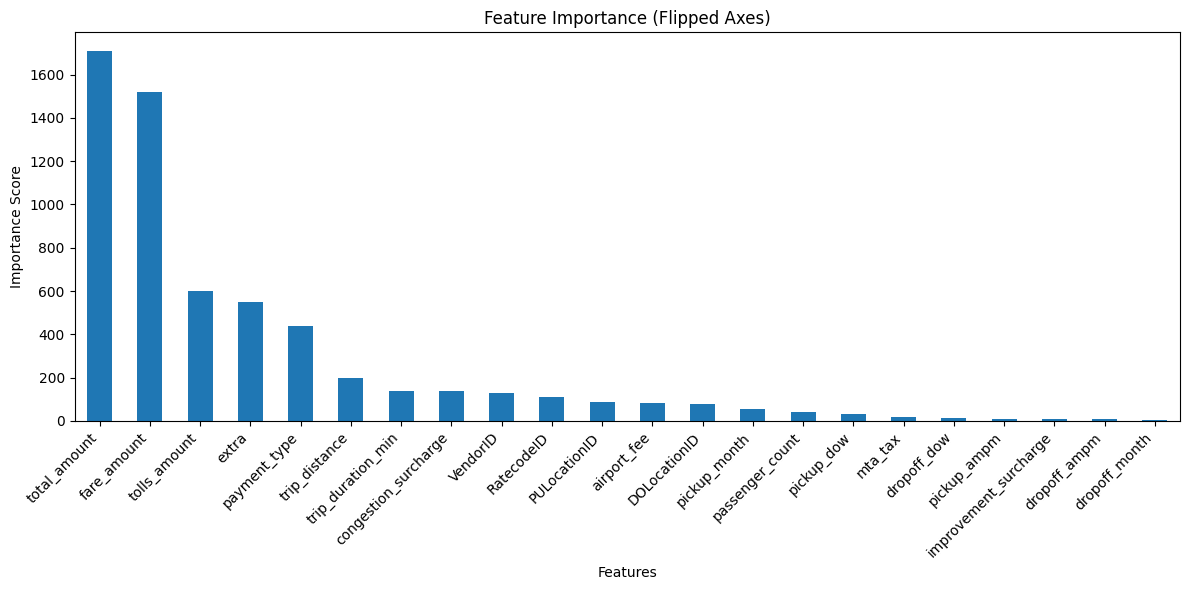

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# fetch feature importance from model
booster = model3.get_booster()
importance = booster.get_score(importance_type='weight')

# convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# sort by importance
importance_df = importance_df.sort_values(
    by='Importance',
    ascending=False
)

# plot data
ax = importance_df.plot(
    kind='bar',                
    x='Feature', 
    y='Importance',
    legend=False,
    figsize=(12, 6)
)

plt.title('Feature Importance (Flipped Axes)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Discuss Feature Importance
We see that the **most important features**, by far, are the **total amount** and the **fare amount** - both relate to the total trip charge. On the other hand, the **date features** we extracted so carefully earlier - are **are among the least important features** when it comes to tips.

### Plot Feature Importance For All Models
We can also check if our previous models show different results (just remember - the previous models know nothing of dates! We only shared them with the third model).

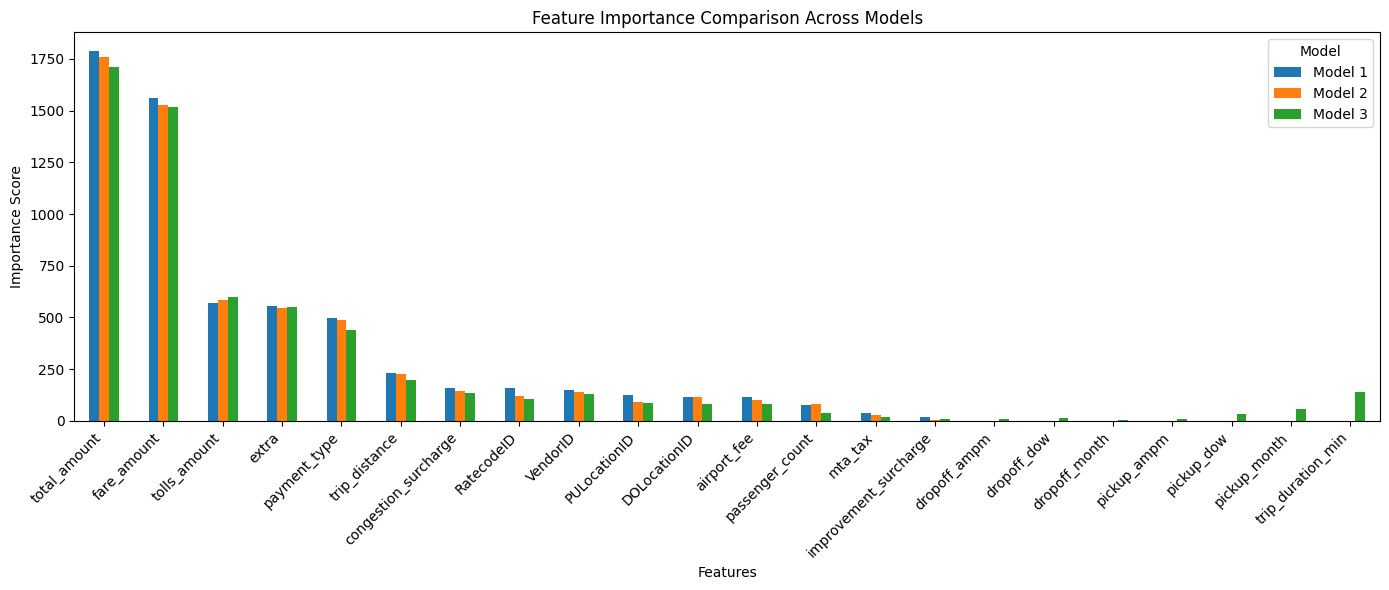

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

models = [model1, model2, model3]
names = ['Model 1', 'Model 2', 'Model 3']

def get_importance_df(model, name):
    """
    get feature important from model
    """
    booster = model.get_booster()
    imp = booster.get_score(importance_type='weight')
    df = pd.DataFrame({
        'Feature': list(imp.keys()),
        name: list(imp.values())
    })
    return df

# combine importances from all models
dfs = [get_importance_df(m, n) for m, n in zip(models, names)]
merged = dfs[0]

for df in dfs[1:]:
    merged = merged.merge(df, on='Feature', how='outer').fillna(0)

# Sort by one model or by mean importance
merged = merged.set_index('Feature')
merged = merged.sort_values(by=names[0], ascending=False).head(30)

# plot side-by-side bars
ax = merged.plot(
    kind='bar',
    figsize=(14, 6)
)

plt.title('Feature Importance Comparison Across Models')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

### Discuss Feature Importance For All Models Results

We see that the importance of features remains consistent for all models. There are no drastic changes, and nothing really stands out.

## Keep Exploring 🧭
Now it's your turn to keep exploring this dataset further and getting better and better scores every time! Best of luck, and I hope you enjoyed this workflow!

See you in the next tutorial! 👋
Mariya Sha